In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6b as of

import tensorflow as tf

import simple_pdf1a as simple_pdf


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.21.5
  tensorflow version:  2.11.0





## Set model and resolution parameters

In [3]:
ndim = 2

##-------------

train_mu = [ 0.0, 1.0 ]



train_rho = [ [-0.6] ]






train_sig = [ 1.0, 1.5 ]


##-------------


true_mu = [ 0.2, 0.8 ]






true_rho  = [ [-0.6] ]



true_sig = [ 0.9, 1.3 ]



#--- nominal
#resolution = [ 0.5, 0.8  ]

#--- poor
resolution = [ 1.0, 1.6  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                




#-- about 3 min
ngen_train = 120000
ngen_true =  12000

#-- about 33 min
ngen_train = 360000
ngen_true =  36000

#-- about 0.3 min
#ngen_train = 40000
#ngen_true =  4000

#-- about 2.5 min
ngen_train = 100000
ngen_true =   10000


of_niter = 10

learning_rate_setval = 0.0005


epochs_setval = 40

batch_size_setval = int( ngen_true )



output_dir = 'simple-pdf-toy-study6b-2d-v1i'

save_step2_model = True



##-- new stuff for pdf estimation

radius = np.zeros( ndim )

for i in range(ndim) :
    radius[i] = resolution[i] 
    
norm_radius2 = 1.0





 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    1.500 *   -0.600 =  -0.9000
   1,  1 : diagonal    2.2500



 True covariance:
   0,  0 : diagonal    0.8100
   0,  1 :              0.900 *    1.300 *   -0.600 =  -0.7020
   1,  1 : diagonal    1.6900


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.440000
True covariance determinant:   0.876096





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.   -0.9 ]
 [-0.9   2.25]]

 Train covariance inverse
[[1.5625     0.625     ]
 [0.625      0.69444444]]

 Train covariance inverse test
[[ 1.00000000e+00 -3.82410153e-17]
 [-5.55111512e-17  1.00000000e+00]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.81  -0.702]
 [-0.702  1.69 ]]

 True covariance inverse
[[1.92901235 0.80128205]
 [0.80128205 0.92455621]]

 True covariance inverse test
[[ 1.00000000e+00  3.80221824e-17]
 [-5.90695584e-17  1.00000000e+00]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )

train_both = np.stack([train_pts, train_det_pts], axis=1)


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : simple-pdf-toy-study6b-2d-v1i/config.txt

2024-03-06 09:19:45.032961

ngen_train 100000
ngen_true  10000
of_niter   10
ndim       2
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  10000


train_mu : [0.0, 1.0]
train_rho : [[-0.6]]
train_sig : [1.0, 1.5]
train_cov : [[ 1.   -0.9 ]
 [-0.9   2.25]]


true_mu : [0.2, 0.8]
true_rho : [[-0.6]]
true_sig : [0.9, 1.3]
true_cov : [[ 0.81  -0.702]
 [-0.702  1.69 ]]


resolution : [1.0, 1.6]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

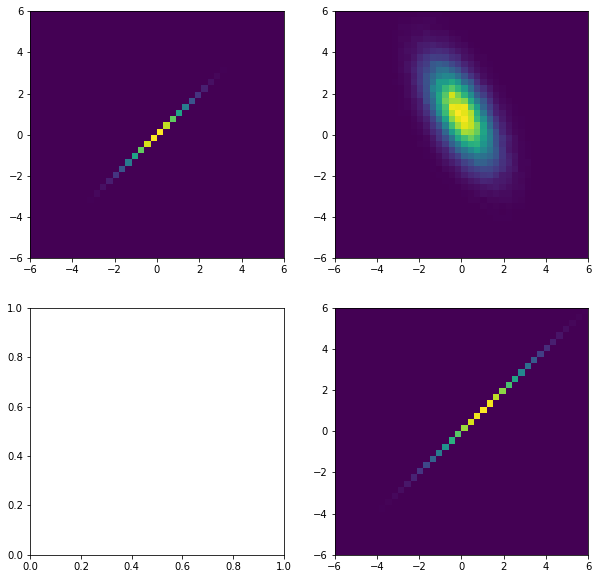

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

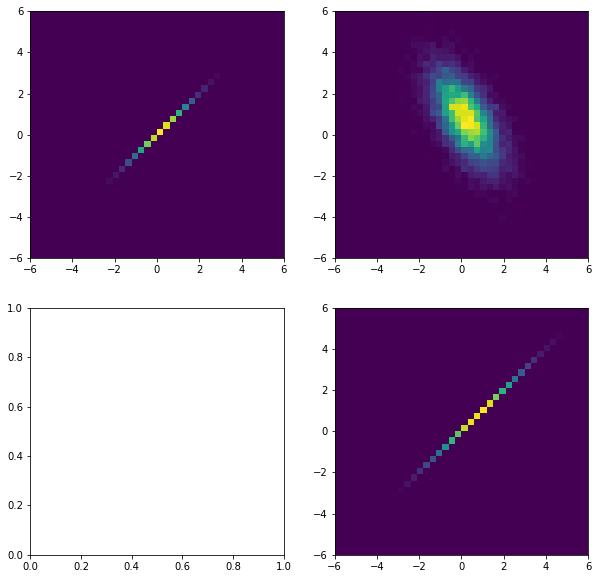

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

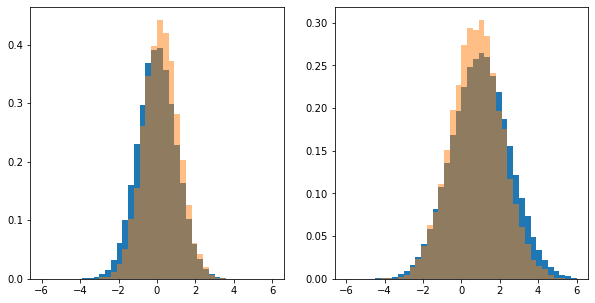

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Estimate initial pdfs
Need pdf values for both train (MC) and true (fake data) at the location of each train event to comput the weight.  If that's too slow, could evaluate both in a grid and use the closest grid point for computing the weights.

To do it in the numpy way (without loops) will need N^2 arrays?  Or 2 x N arrays?

Did initial testing on laptop (work/ai/jupyter-notebooks).

To make things efficient, especially beyond one iteration, calculate a N x N array of booleans (for the MC), where it saves for each event pair whether the events are within the radius defining the density estimate.

Since the weights are applied to the MC, will need a Ndata x Nmc array of booleans for the data?

For the data, there are no evolving weights, so what's really needed is just a measure of the probability density at the location of the MC events.  Calculate it once and then use the same numbers in each iteration.


In [19]:
#global train_train_det_within_sphere
train_train_det_within_sphere = np.zeros( shape=(ngen_train ,ngen_train), dtype=bool )

#global train_train_gen_within_sphere
train_train_gen_within_sphere = np.zeros( shape=(ngen_train ,ngen_train), dtype=bool )

In [20]:
%%time

rd = simple_pdf.simple_pdf1a( train_both, true_det_pts, 
                             train_train_det_within_sphere, train_train_gen_within_sphere,
                             of_niter, radius, norm_radius2, True, True )




  ======== simple_pdf1a


  shape of theta0_S : (100000, 2)
  shape of theta0_G : (100000, 2)
  shape of theta_unknown_S : (10000, 2)

  iterations = 10

  scales : [1.  1.6]
  radius = 1.00

  compute radii :  True
  ndim : 2





 Calculating distance between all pairs of MC events
             0 /       100000
         10000 /       100000
         20000 /       100000
         30000 /       100000
         40000 /       100000
         50000 /       100000
         60000 /       100000
         70000 /       100000
         80000 /       100000
         90000 /       100000
  --- Done calculating 
 train_train_det_within_sphere 
[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False  True]
 [False False False ... False  True False]
 [False False False ...  True False  True]]


 Calculating pdf from data, detector features
true_det_simple_pdf_at_train_points
[1.56606

In [21]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

<function matplotlib.pyplot.show(close=None, block=None)>

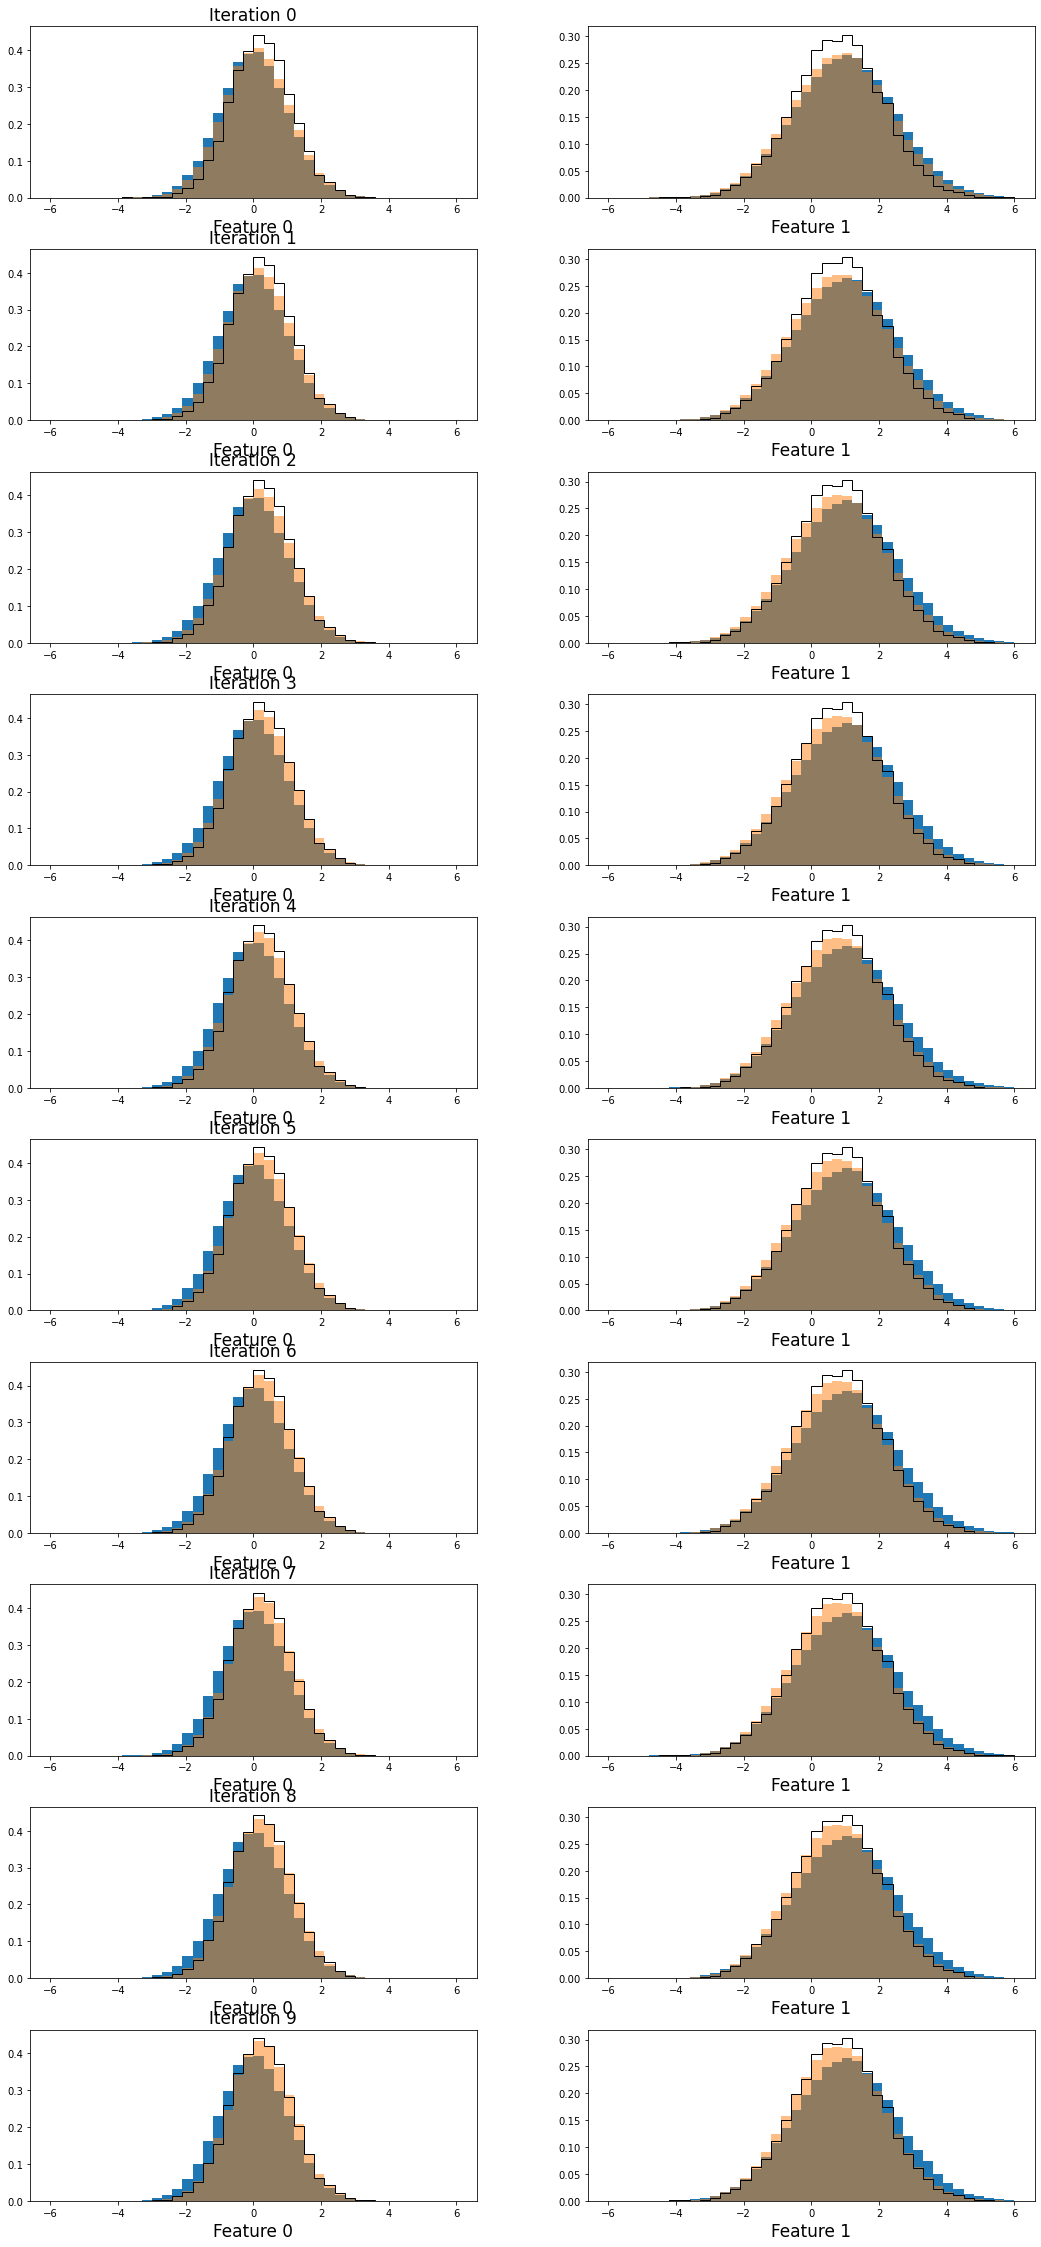

In [22]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [23]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

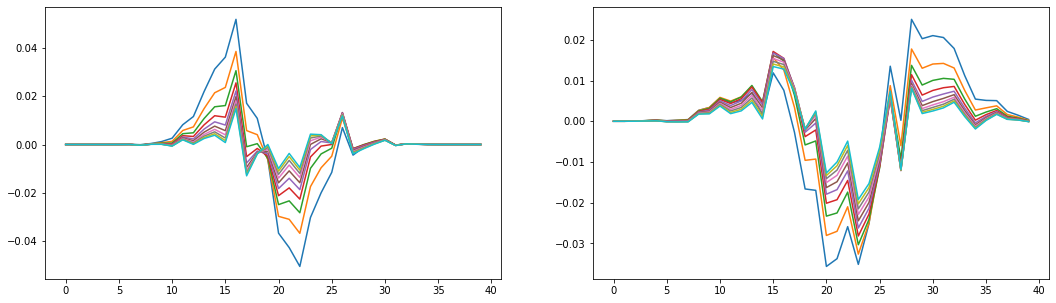

In [24]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

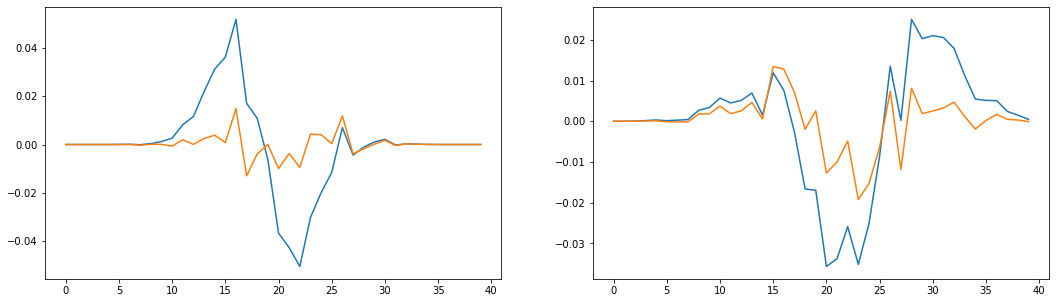

In [25]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

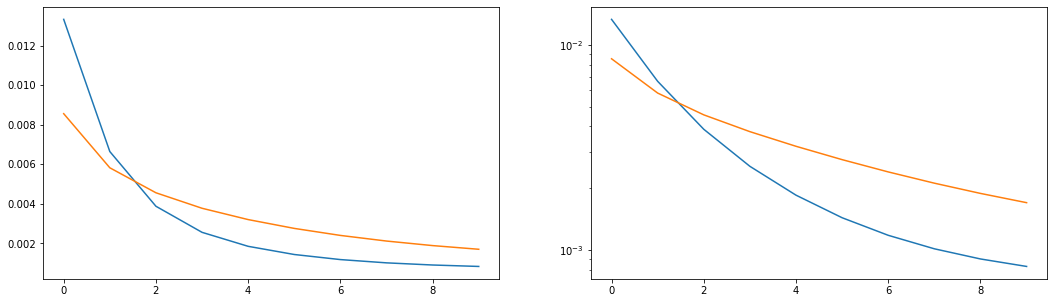

In [26]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

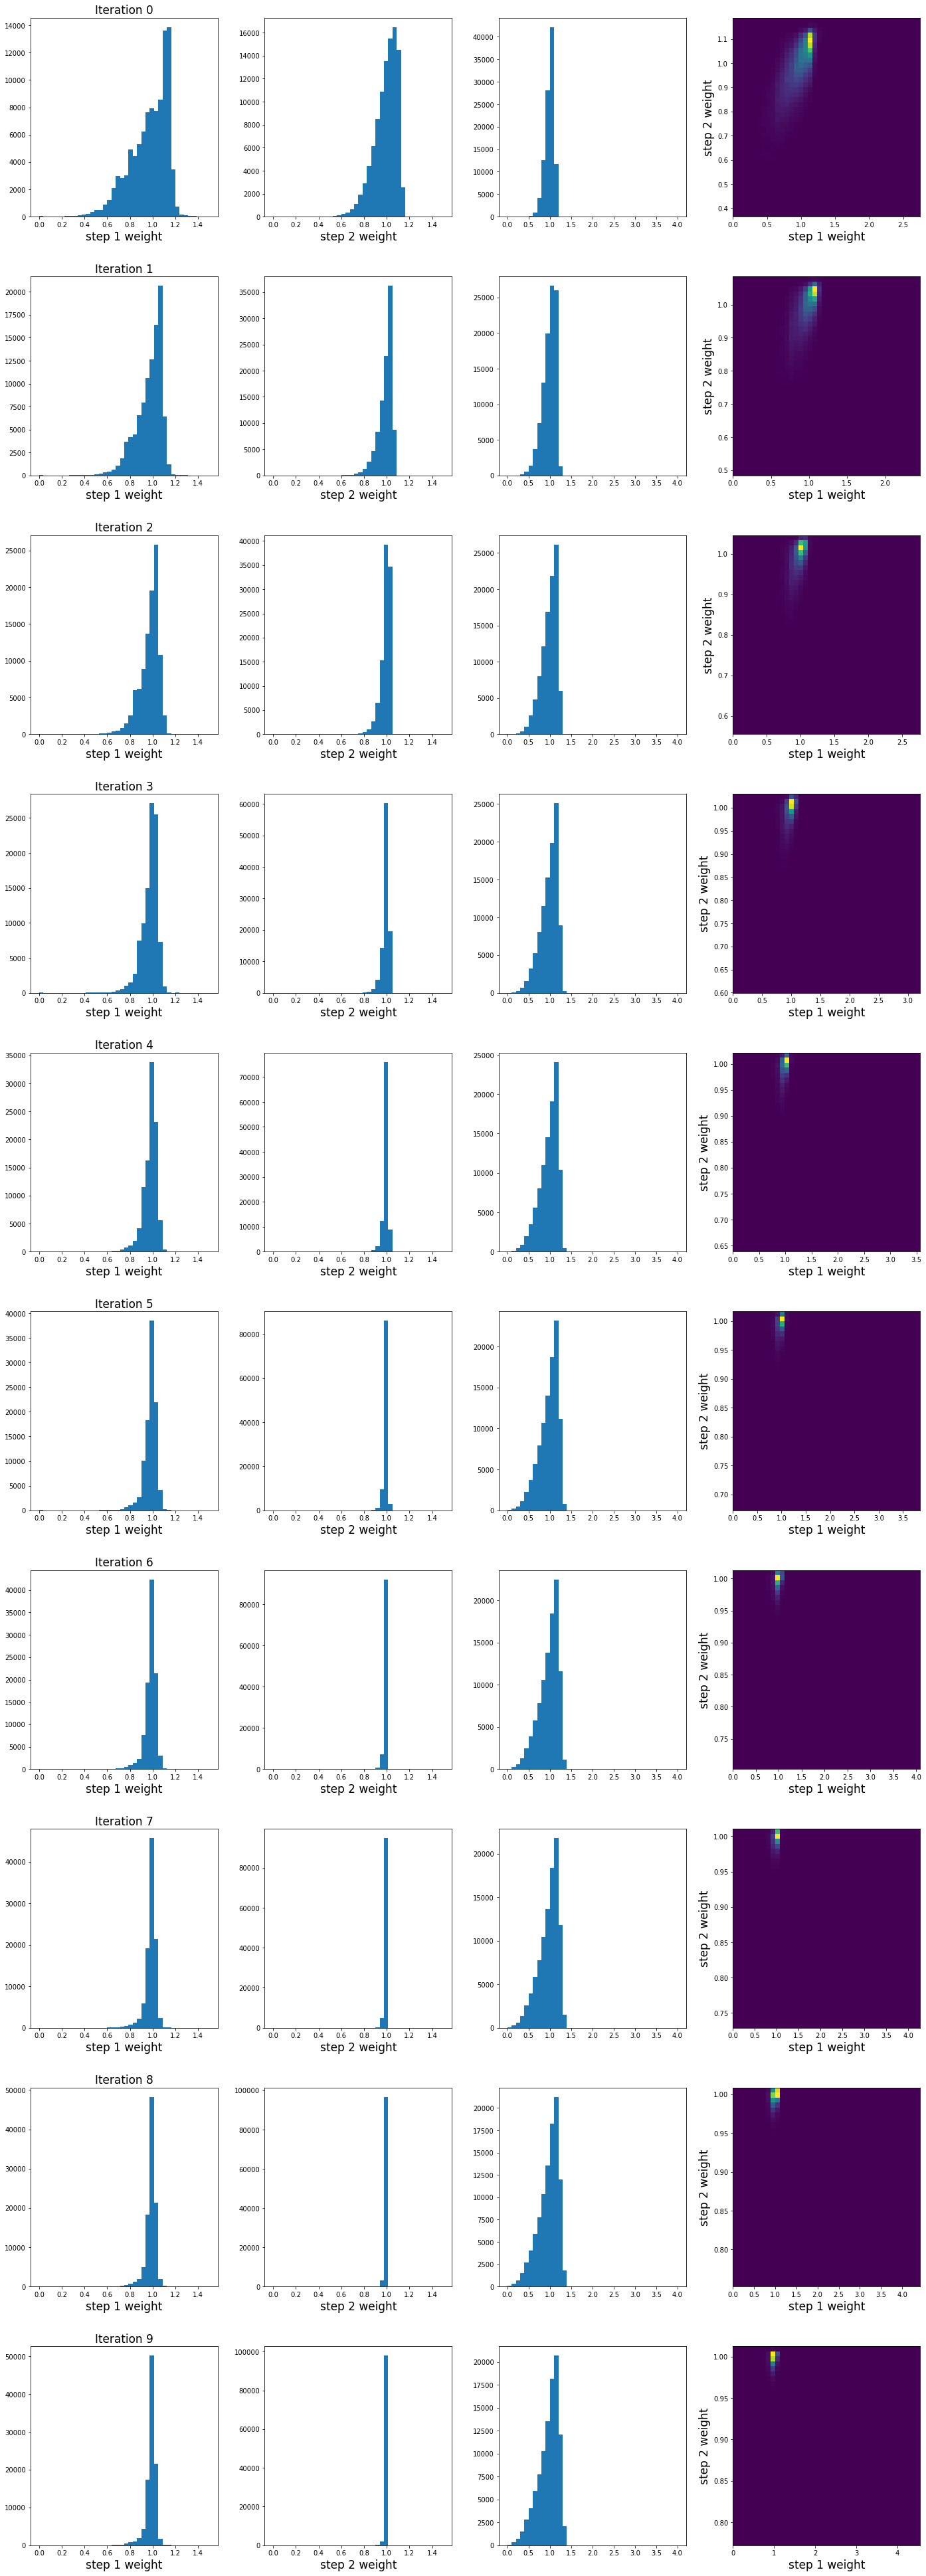

In [27]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,4.] )
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

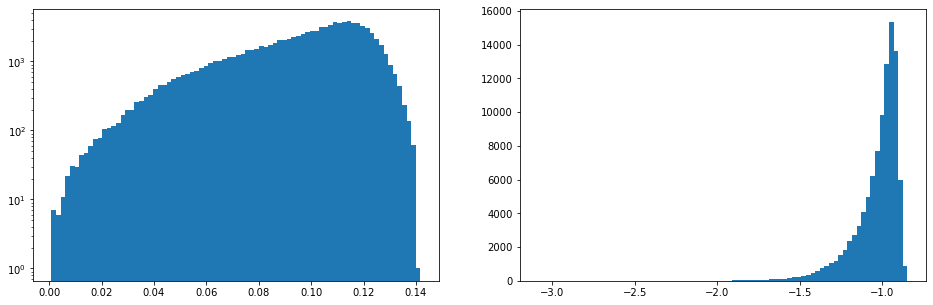

In [28]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

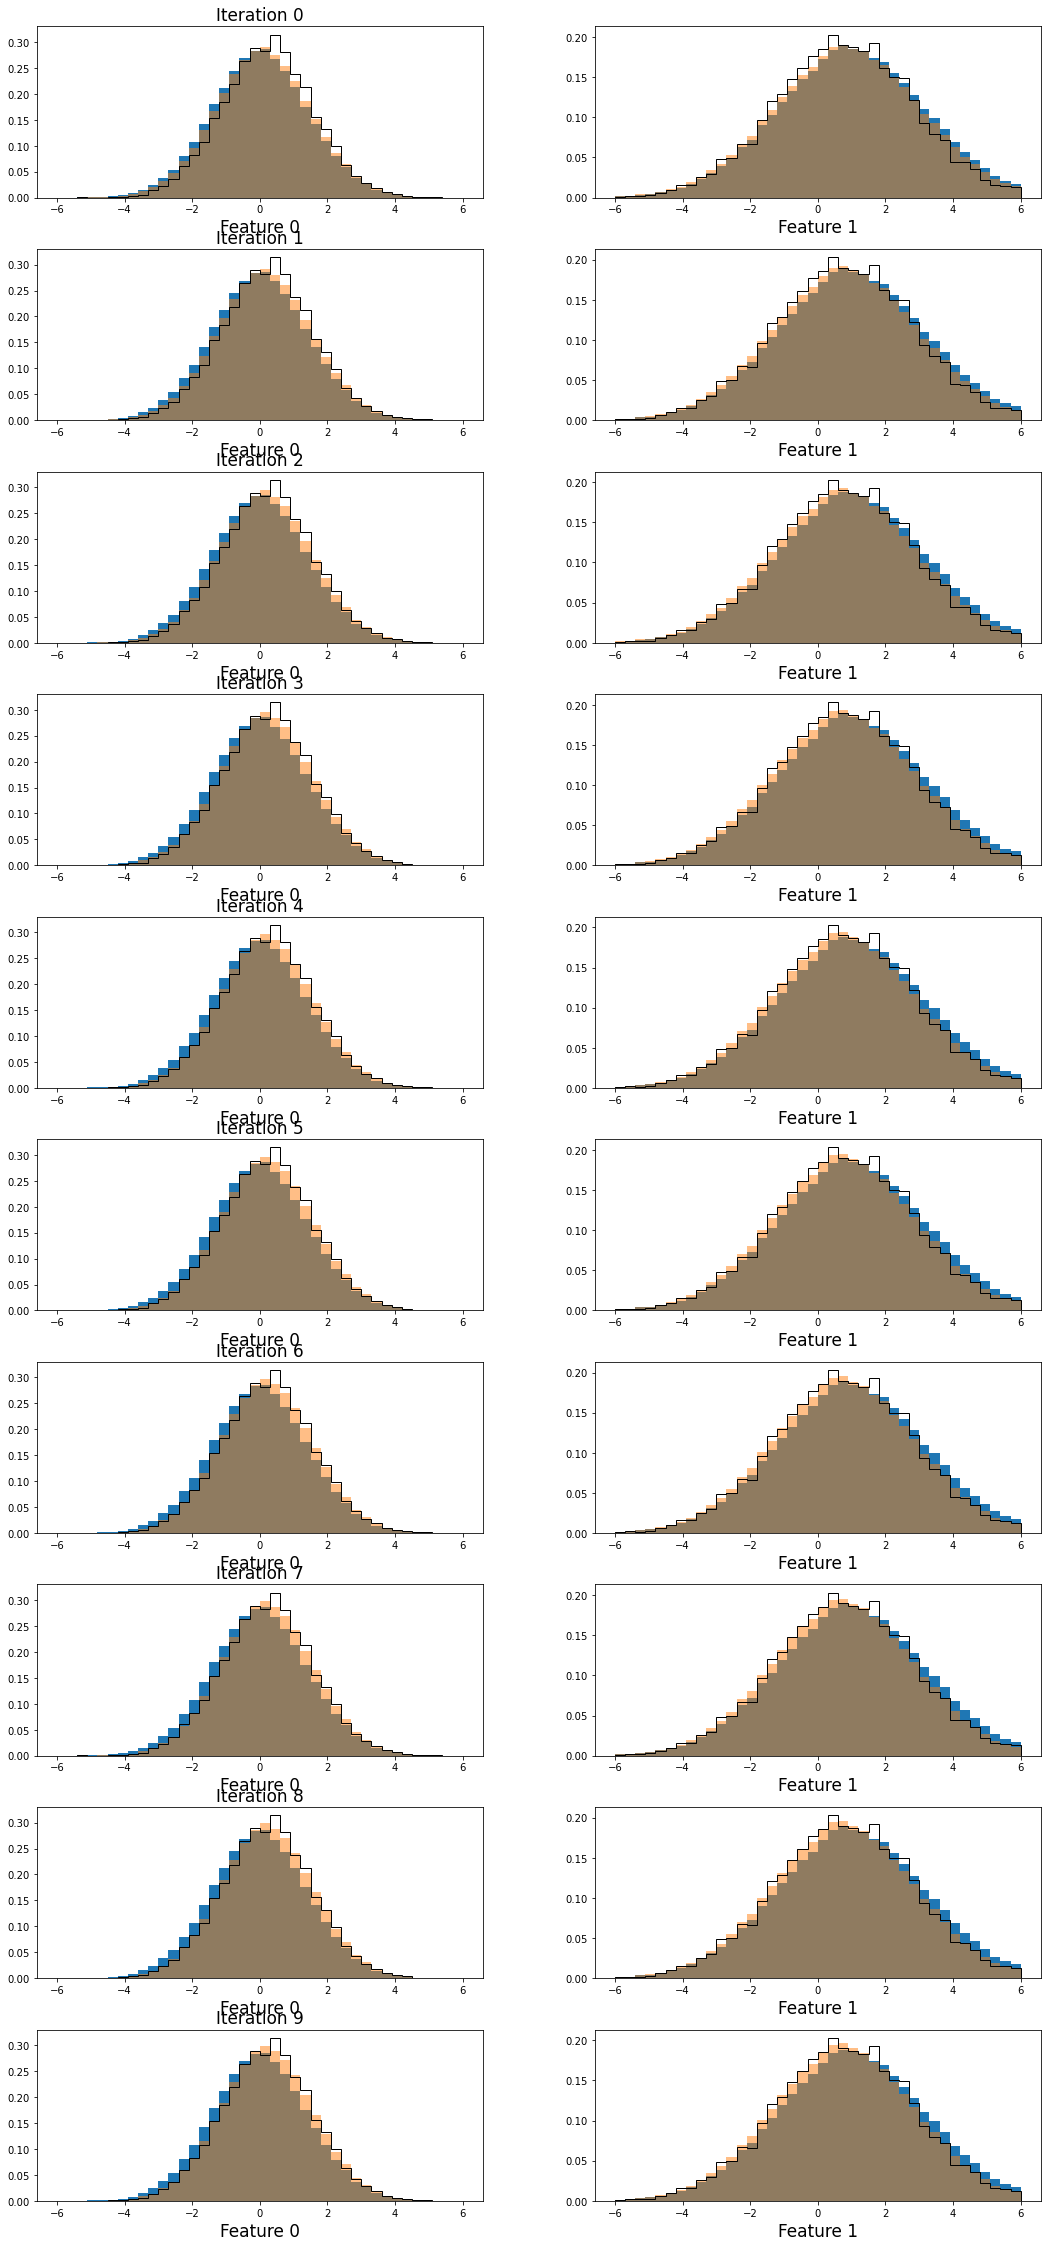

In [29]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )


    else :
        
        for di in range(ndim) :

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [30]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

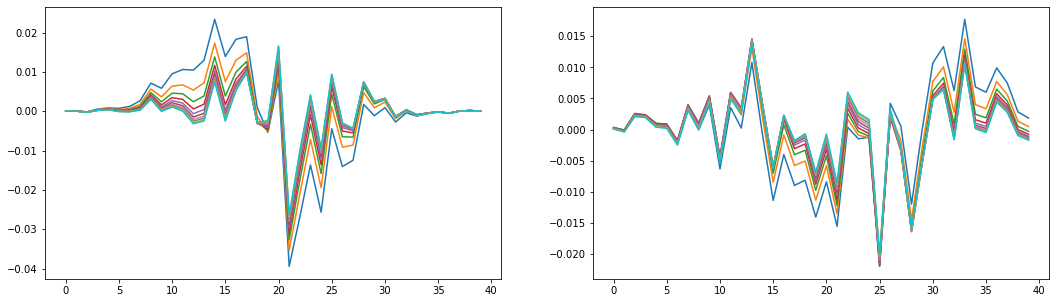

In [31]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

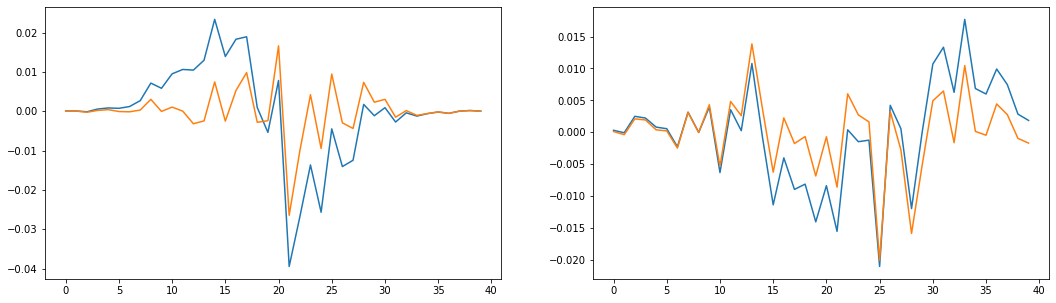

In [32]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

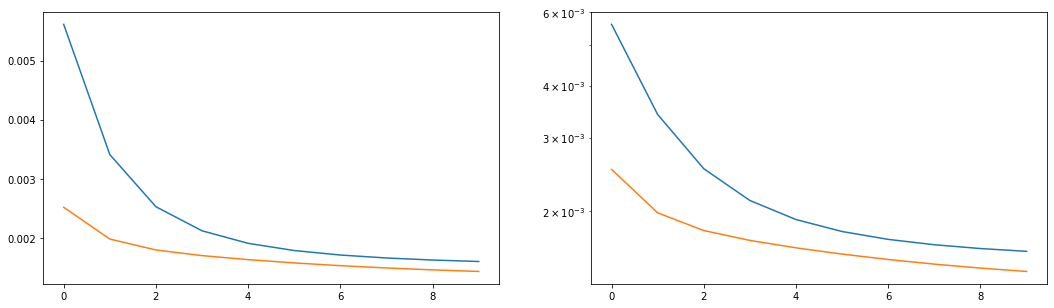

In [33]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [34]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.970  rms 0.171      step 2 mean  0.990  rms 0.103
  iter  1 : step 1 mean  0.968  rms 0.120      step 2 mean  0.988  rms 0.063
  iter  2 : step 1 mean  0.971  rms 0.093      step 2 mean  0.989  rms 0.042
  iter  3 : step 1 mean  0.974  rms 0.079      step 2 mean  0.991  rms 0.030
  iter  4 : step 1 mean  0.978  rms 0.070      step 2 mean  0.993  rms 0.022
  iter  5 : step 1 mean  0.980  rms 0.065      step 2 mean  0.994  rms 0.018
  iter  6 : step 1 mean  0.982  rms 0.062      step 2 mean  0.995  rms 0.014
  iter  7 : step 1 mean  0.984  rms 0.060      step 2 mean  0.996  rms 0.012
  iter  8 : step 1 mean  0.986  rms 0.058      step 2 mean  0.996  rms 0.010
  iter  9 : step 1 mean  0.987  rms 0.057      step 2 mean  0.997  rms 0.008


<function matplotlib.pyplot.show(close=None, block=None)>

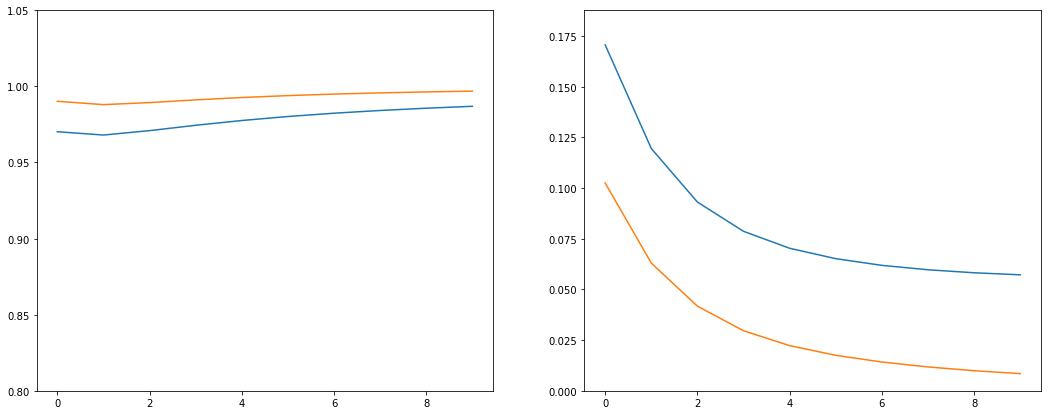

In [35]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show